In [1]:
# imports
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

import wrangle as w
import prepare as p

### Models today
- Ordinary Least Squares
- LASSO + LARS
- Polynomial Regression
- Generalized Linear Model

## Ordinary Least Squares (OLS)

OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points
### examine the model
   
$y = \beta_0 + \beta_i x_i$

**intercept** ($\beta_0$): Value we predict if x is 0. Depending on our x variables, this may not be valuable

**coefficients** ($\beta_i$): Define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a coef unit change in y, holding all other independent variables constant

### Multiple Regression
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$

## LassoLars
LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression
- Performs intrinsic feature selection and noise reduction to avoid overfitting
- The most important hyperparameter is alpha
    - alpha determines the degree of regularization applied to the model
    - The lowest alpha is zero, and this represents no regularization (identical to OLS)
    - There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    - Generally speaking, the higher the alpha, the lower your risk for overfitting
    - alpha = 1.0 is a good place to start

## Polynomial Regression
$y = \beta_0 + \beta_i x + \beta_k x^k$

We can introduce higher powers of our independent variables, meaning the model can predict a curve instead of a line 

However, the more curves you introduce, the more likely your model is to be overfit!
#### process
1. create new features based on degrees
2. fit on a linear regression model

## Generalized Linear Model (GLM)
The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:

    power = 0: Normal Distribution
    power = 1: Poisson Distribution
    power = (1,2): Compound Distribution
    power = 2: Gamma Distribution
    power = 3: Inverse Gaussian Distribution

# Exercises

### 1. Select a dataset with a continuous target variable.



In [2]:
df = w.wrangle_zillow()
df.head()

,year,beds,baths,area,prop_value,prop_tax,county
0,2005,4,2.0,3633,296425,6941.39,LA
1,2011,3,4.0,1620,847770,10244.94,LA
2,1926,3,2.0,2077,646760,7924.68,LA
6,1950,3,1.0,1244,169471,2532.88,LA
7,1950,3,2.0,1300,233266,3110.99,LA


### 2. Be sure your data is prepared (no missing values, numeric data types) and split into samples.



In [3]:
train,val,test = w.split_data(df)
train.head()

,year,beds,baths,area,prop_value,prop_tax,county
558946,1953,2,1.0,989,141500,2446.95,LA
156655,1972,4,2.0,2054,555982,6570.12,LA
2055932,1945,2,1.0,774,237093,2945.65,LA
687070,1958,3,2.0,1570,431696,5390.83,LA
1496477,2007,4,3.0,1919,598904,6709.22,Orange


In [4]:
# county doesn't seem to help much so not going to encode, just drop
Xtr,Xv,Xt = train.drop(columns=['prop_value','prop_tax','county']),val.drop(columns=['prop_value','prop_tax','county']),test.drop(columns=['prop_value','prop_tax','county'])
Xtr.head()

,year,beds,baths,area
558946,1953,2,1.0,989
156655,1972,4,2.0,2054
2055932,1945,2,1.0,774
687070,1958,3,2.0,1570
1496477,2007,4,3.0,1919


In [5]:
ytr = train[['prop_value']]
yv,yt = val[['prop_value']],test[['prop_value']]
ytr[:5]

,prop_value
558946,141500
156655,555982
2055932,237093
687070,431696
1496477,598904


In [6]:
# 5 diff scaling methods
scale = Xtr.columns.to_list()
Xtr_m,Xv_m,Xt_m=p.mm_zillow(train,val,test,scale)
Xtr_s,Xv_s,Xt_s=p.std_zillow(train,val,test,scale)
Xtr_r,Xv_r,Xt_r=p.robs_zillow(train,val,test,scale)
Xtr_n,Xv_n,Xt_n=p.qtf_zillow(train,val,test,'normal',scale)
Xtr_u,Xv_u,Xt_u=p.qtf_zillow(train,val,test,'uniform',scale)

In [7]:
Xtr_m.head()

,year_s,beds_s,baths_s,area_s
558946,0.706977,0.066667,0.025641,0.043522
156655,0.795349,0.200000,0.076923,0.090437
2055932,0.669767,0.066667,0.025641,0.034051
687070,0.730233,0.133333,0.076923,0.069116
1496477,0.958140,0.200000,0.128205,0.084490


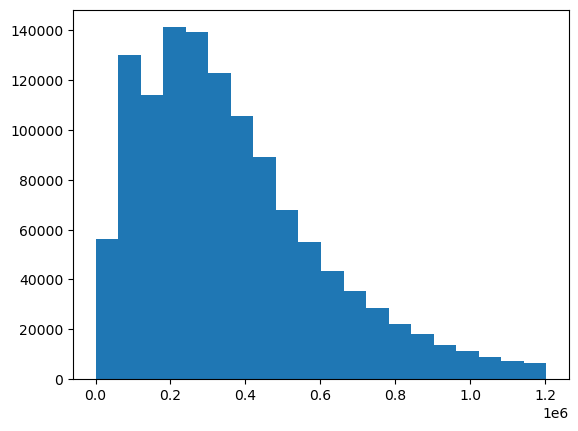

In [8]:
# check dist
plt.hist(ytr,bins=20)
plt.show()

### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [9]:
pred_mean = ytr.mean()[0]
ytr = ytr.assign(pred_mean=pred_mean)
yv = yv.assign(pred_mean=pred_mean)
pred_median = ytr.median()[0]
ytr = ytr.assign(pred_median=pred_median)
yv = yv.assign(pred_median=pred_median)
rmse_tr = mean_squared_error(ytr.prop_value,ytr.pred_mean)**.5
rmse_v = mean_squared_error(yv.prop_value,yv.pred_mean)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_mean)
r2_v = r2_score(yv.prop_value, yv.pred_mean)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'bl_mean',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list = [metrics_info]
rmse_tr = mean_squared_error(ytr.prop_value,ytr.pred_median)**.5
rmse_v = mean_squared_error(yv.prop_value,yv.pred_median)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_median)
r2_v = r2_score(yv.prop_value, yv.pred_median)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'bl_median',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list.append(metrics_info)

rmse tr:243160.25837650846
rmse v: 242999.72814500416
rmse tr:248337.20889683734
rmse v: 248012.9176358591


#### LinearRegression

In [10]:
lr = LinearRegression()
lr.fit(Xtr_m,ytr[['prop_value']])
ytr = ytr.assign(pred_lr=lr.predict(Xtr_m))
yv = yv.assign(pred_lr=lr.predict(Xv_m))
rmse_tr = mean_squared_error(ytr[['prop_value']],ytr.pred_lr)**.5
rmse_v = mean_squared_error(yv[['prop_value']],yv.pred_lr)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_lr)
r2_v = r2_score(yv.prop_value, yv.pred_lr)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'LinearRegression',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list.append(metrics_info)

rmse tr:205020.35936989443
rmse v: 205082.36996953134


#### LassoLars

In [11]:
ll = LassoLars(alpha=1,normalize=False)
ll.fit(Xtr_m,ytr[['prop_value']])
ytr = ytr.assign(pred_ll=ll.predict(Xtr_m))
yv = yv.assign(pred_ll=ll.predict(Xv_m))
rmse_tr = mean_squared_error(ytr[['prop_value']],ytr.pred_ll)**.5
rmse_v = mean_squared_error(yv[['prop_value']],yv.pred_ll)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_ll)
r2_v = r2_score(yv.prop_value, yv.pred_ll)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'LassoLars',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list.append(metrics_info)

rmse tr:205020.3672942995
rmse v: 205082.22715090433


#### PolynomialFeatures

In [12]:
pf = PolynomialFeatures(degree=2)
Xtr_m_d2 = pf.fit_transform(Xtr_m)
Xv_m_d2 = pf.transform(Xv_m)
Xt_m_d2 = pf.transform(Xt_m)
lp = LinearRegression()
lp.fit(Xtr_m_d2,ytr[['prop_value']])
ytr = ytr.assign(pred_lp=lp.predict(Xtr_m_d2))
yv = yv.assign(pred_lp=lp.predict(Xv_m_d2))
rmse_tr = mean_squared_error(ytr[['prop_value']],ytr.pred_lp)**.5
rmse_v = mean_squared_error(yv[['prop_value']],yv.pred_lp)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_lp)
r2_v = r2_score(yv.prop_value, yv.pred_lp)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'PolynomialRegression',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list.append(metrics_info)

rmse tr:203614.51024190141
rmse v: 203775.83080414517


#### TweedieRegressor (GLM)

In [13]:
lm = TweedieRegressor(power=1,alpha=0)
lm.fit(Xtr_m,ytr.prop_value)
ytr = ytr.assign(pred_lm=lm.predict(Xtr_m))
yv = yv.assign(pred_lm=lm.predict(Xv_m))
rmse_tr = mean_squared_error(ytr[['prop_value']],ytr.pred_lm)**.5
rmse_v = mean_squared_error(yv[['prop_value']],yv.pred_lm)**.5
r2_tr = r2_score(ytr.prop_value, ytr.pred_lm)
r2_v = r2_score(yv.prop_value, yv.pred_lm)
print(f'rmse tr:{rmse_tr}\nrmse v: {rmse_v}')
metrics_info = {
        'model':'TweedieRegressor',
        'rmse_tr':rmse_tr,
        'rmse_v':rmse_v,
        'r2_tr':r2_tr,
        'r2_v':r2_v
    }
metrics_list.append(metrics_info)

rmse tr:240838.24197995264
rmse v: 450955.1502095566


In [14]:
metrics_df = pd.DataFrame(metrics_list,)
metrics_df

,model,rmse_tr,rmse_v,r2_tr,r2_v
0,bl_mean,243160.258377,242999.728145,0.000000,-0.000011
1,bl_median,248337.208897,248012.917636,-0.043034,-0.041698
2,LinearRegression,205020.359370,205082.369970,0.289100,0.287721
3,LassoLars,205020.367294,205082.227151,0.289099,0.287722
4,PolynomialRegression,203614.510242,203775.830804,0.298816,0.296768
5,TweedieRegressor,240838.241980,450955.150210,0.019007,-2.443976


#### Crazy Experiment cycling through all

In [15]:
# wrangle
df = w.wrangle_zillow()
df

,year,beds,baths,area,prop_value,prop_tax,county
0,2005,4,2.0,3633,296425,6941.39,LA
1,2011,3,4.0,1620,847770,10244.94,LA
2,1926,3,2.0,2077,646760,7924.68,LA
6,1950,3,1.0,1244,169471,2532.88,LA
7,1950,3,2.0,1300,233266,3110.99,LA
...,...,...,...,...,...,...,...
2140230,2015,4,4.0,4375,422400,13877.56,LA
2140231,2015,4,3.0,2262,960756,13494.52,Orange
2140232,2014,4,4.5,3127,536061,6244.16,Orange
2140233,2015,3,2.5,1974,424353,5302.70,Orange


In [16]:
# encode
df = p.encode_county(df)
# extra features
df = df.assign(rooms=df.beds+df.baths)
df = df.assign(bb_area=df.beds*70+df.baths*30)
# split tr,v,t
train,val,test = w.split_data(df)
# split X and y
Xtr,Xv,Xt = train.drop(columns=['prop_value','prop_tax','county']),val.drop(columns=['prop_value','prop_tax','county']),test.drop(columns=['prop_value','prop_tax','county'])
ytr,yv,yt = train[['prop_value']],val[['prop_value']],test[['prop_value']]
# 5 diff scaling methods
scale = Xtr.columns.to_list()
Xtr_m,Xv_m,Xt_m=p.mm_zillow(train,val,test,scale)
Xtr_s,Xv_s,Xt_s=p.std_zillow(train,val,test,scale)
Xtr_r,Xv_r,Xt_r=p.robs_zillow(train,val,test,scale)
Xtr_m

,year_s,beds_s,baths_s,area_s,Orange_s,Ventura_s,rooms_s,bb_area_s
558946,0.706977,0.066667,0.025641,0.043522,0.0,0.0,0.049180,0.056106
156655,0.795349,0.200000,0.076923,0.090437,0.0,0.0,0.147541,0.168317
2055932,0.669767,0.066667,0.025641,0.034051,0.0,0.0,0.049180,0.056106
687070,0.730233,0.133333,0.076923,0.069116,0.0,0.0,0.114754,0.122112
1496477,0.958140,0.200000,0.128205,0.084490,1.0,0.0,0.180328,0.188119
...,...,...,...,...,...,...,...,...
723557,0.716279,0.266667,0.076923,0.079732,0.0,0.0,0.180328,0.214521
587409,0.790698,0.133333,0.076923,0.056033,1.0,0.0,0.114754,0.122112
1801850,0.641860,0.066667,0.025641,0.050747,0.0,0.0,0.049180,0.056106
352380,0.679070,0.133333,0.025641,0.050086,0.0,0.0,0.081967,0.102310


In [20]:
# LinearRegression()
# LassoLars(alpha=1.0) # alpha 0 same as LinearRegression
# PolynomialFeatures(degree=2), LinearRegression() # experiment with other models
# TweedieRegressor(power=2, alpha=0) # power 2 for gamma dist or 1 poisson span of 2017?

def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

def reg_mods(Xtr,ytr,Xv,yv,features=None):
    '''
    send in X_train,y_train,X_val,y_val,and list of features
    so that function will run through linear regression, lasso lars,
    polynomial feature regression, and tweedie regressor (glm)
    - diff feature combos
    - output as df
    '''
    if features is None:
        features = Xtr.columns.to_list()
    # baseline as mean
    pred_mean = ytr.mean()[0]
    ytr_p = ytr.assign(pred_mean=pred_mean)
    yv_p = yv.assign(pred_mean=pred_mean)
    rmse_tr = mean_squared_error(ytr,ytr_p.pred_mean)**.5
    rmse_v = mean_squared_error(yv,yv_p.pred_mean)**.5
    r2_tr = r2_score(ytr, ytr_p.pred_mean)
    r2_v = r2_score(yv, yv_p.pred_mean)
    output = {
            'model':'bl_mean',
            'features':'None',
            'params':'None',
            'rmse_tr':rmse_tr,
            'rmse_v':rmse_v,
            'r2_tr':r2_tr,
            'r2_v':r2_v
        }
    metrics = [output]
    # baseline as median
    pred_median = ytr.median()[0]
    ytr_p,yv_p=ytr,yv
    ytr_p = ytr_p.assign(pred_median=pred_median)
    yv_p = yv_p.assign(pred_median=pred_median)
    rmse_tr = mean_squared_error(ytr,ytr_p.pred_median)**.5
    rmse_v = mean_squared_error(yv,yv_p.pred_median)**.5
    r2_tr = r2_score(ytr, ytr_p.pred_median)
    r2_v = r2_score(yv, yv_p.pred_median)
    output = {
            'model':'bl_median',
            'features':'None',
            'params':'None',
            'rmse_tr':rmse_tr,
            'rmse_v':rmse_v,
            'r2_tr':r2_tr,
            'r2_v':r2_v
        }
    metrics.append(output)
    # create iterable for feature combos
    for r in range(1,(len(features)+1)):
        # print(r)
        # cycle through feature combos for linear reg
        # print('start lin reg')
        for feature in itertools.combinations(features,r):
            f = list(feature)
            # linear regression
            lr = LinearRegression()
            lr.fit(Xtr[f],ytr)
            # metrics
            pred_lr_tr = lr.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lr_tr)
            pred_lr_v = lr.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_lr_v)
            # table-ize
            output ={
                    'model':'LinearRegression',
                    'features':f,
                    'params':'None',
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'rmse_v':rmse_v,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and alphas for lasso lars
        # print('start lasso lars')
        for feature in itertools.combinations(features,r):
            f = list(feature)
            # lasso lars
            ll = LassoLars(alpha=1,normalize=False)
            ll.fit(Xtr[f],ytr)
            # metrics
            pred_ll_tr = ll.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_ll_tr)
            pred_ll_v = ll.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_ll_v)
            # table-ize
            output ={
                    'model':'LassoLars',
                    'features':f,
                    'params':'alpha=1',
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'rmse_v':rmse_v,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and degrees for polynomial feature reg
        # print('start poly reg')
        for feature,d in itertools.product(itertools.combinations(features,r),[3,4]):
            f = list(feature)
            # polynomial feature regression
            pf = PolynomialFeatures(degree=d)
            Xtr_pf = pf.fit_transform(Xtr[f])
            Xv_pf = pf.transform(Xv[f])
            lp = LinearRegression()
            lp.fit(Xtr_pf,ytr)
            # metrics
            pred_lp_tr = lp.predict(Xtr_pf)
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lp_tr)
            pred_lp_v = lp.predict(Xv_pf)
            rmse_v,r2_v = metrics_reg(yv,pred_lp_v)
            # table-ize
            output ={
                    'model':'PolynomialFeature',
                    'features':f,
                    'params':f'degree={d}',
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'rmse_v':rmse_v,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos, alphas, and powers for tweedie reg
        # print('start tweedie reg')
        for feature,a in itertools.product(itertools.combinations(features,r),[1,2]):
            f = list(feature)
            # print(f,' - ',a)
            # tweedie regressor glm
            lm = TweedieRegressor(power=2,alpha=a)
            # print('model made')
            lm.fit(Xtr[f],ytr.prop_value)
            # print('model fit')
            # metrics
            pred_lm_tr = lm.predict(Xtr[f])
            # print('pred tr made',pred_lm_tr.max())
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lm_tr)
            # print('metric tr made')
            pred_lm_v = lm.predict(Xv[f])
            # print('pred v made')
            rmse_v,r2_v = metrics_reg(yv,pred_lm_v)
            # print('metric v made')
            # table-ize
            output ={
                    'model':'TweedieRegressor',
                    'features':f,
                    'params':f'power=2,alpha={a}',
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'rmse_v':rmse_v,
                    'r2_v':r2_v
                }
            # print('output made')
            metrics.append(output)
            # print('output append')
    return pd.DataFrame(metrics)

In [21]:
met1 = reg_mods(Xtr_m,ytr,Xv_m,yv)
met1 = met1.assign(scale='min-max')

In [22]:
met2 = reg_mods(Xtr_s,ytr,Xv_s,yv)
met2 = met2.assign(scale='standard')

In [24]:
met = pd.concat([met1,met2],ignore_index=True)
met

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v,scale
0,bl_mean,None,None,243160.258377,242999.728145,0.000000,-0.000011,min-max
1,bl_median,None,None,248337.208897,248012.917636,-0.043034,-0.041698,min-max
2,LinearRegression,[year_s],None,232985.579876,232865.390082,0.081936,0.081660,min-max
3,LinearRegression,[beds_s],None,234805.860828,234730.989659,0.067535,0.066887,min-max
4,LinearRegression,[baths_s],None,216661.271369,216643.188824,0.206079,0.205153,min-max
...,...,...,...,...,...,...,...,...
3059,LassoLars,"[year_s, beds_s, baths_s, area_s, Orange_s, Ve...",alpha=1,204259.366222,204356.611986,0.294367,0.292754,standard
3060,PolynomialFeature,"[year_s, beds_s, baths_s, area_s, Orange_s, Ve...",degree=3,199133.243670,199112.077389,0.329340,0.328589,standard
3061,PolynomialFeature,"[year_s, beds_s, baths_s, area_s, Orange_s, Ve...",degree=4,198669.824888,199839.916313,0.332458,0.323671,standard
3062,TweedieRegressor,"[year_s, beds_s, baths_s, area_s, Orange_s, Ve...","power=2,alpha=1",212532.081235,212965.898022,0.236052,0.231907,standard


In [25]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(met):
    # Performed 1 aggregation grouped on column: 'model'
    met = met.loc[met.groupby('model')['r2_v'].agg('idxmax').to_list()]
    # Sort by column: 'r2_v' (descending)
    met = met.sort_values(['r2_v'], ascending=[False])
    return met

met_clean = clean_data(met.copy())
met_clean.head()

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v,scale
2920,PolynomialFeature,"[year_s, beds_s, area_s, Orange_s, Ventura_s, ...",degree=3,199139.860542,199052.684930,0.329296,0.328989,standard
1353,LassoLars,"[year_s, baths_s, area_s, Orange_s, Ventura_s,...",alpha=1,204259.393156,204356.466620,0.294367,0.292755,min-max
1483,LinearRegression,"[year_s, beds_s, area_s, Orange_s, Ventura_s, ...",None,204259.421111,204356.543758,0.294367,0.292754,min-max
2984,TweedieRegressor,"[year_s, baths_s, area_s, Orange_s, Ventura_s,...","power=2,alpha=1",212314.497655,212883.419825,0.237615,0.232502,standard
0,bl_mean,None,None,243160.258377,242999.728145,0.000000,-0.000011,min-max
